In [53]:
from pathlib import Path

import ResNet
from ResNetData import ResNetDataPreprocessor, ResNetDataset
from ResNetTrain import *

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import torchvision.models as models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import os


In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

DATASET_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/mandatory1_data/')
BASE_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/')

print("Fetching data.")
preprocessor = ResNetDataPreprocessor(dataset_path=DATASET_PATH, base_path=BASE_PATH)

layers_to_analyse = [3, 15, 34]


Fetching data.
Success! Train, validation and test sets are disjoint.


In [55]:
model = models.resnet34(pretrained=True).to(device)
model.eval()

for name, module in model.named_children():
    print(name)



/mnt/e/ml_projects/in3310/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/e/ml_projects/in3310/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [56]:
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
feature_maps = {}

def hook_function(module, input, output, layer_name):
    feature_maps[layer_name] = output.detach().cpu()

hooks = []
for name in layer_names:
    layer = dict(model.named_children())[name]  # Finn riktig lag i modellen
    hook = layer.register_forward_hook(lambda module, input, output, name=name: hook_function(module, input, output, name))
    hooks.append(hook)

In [57]:

# Definer transformasjoner for datasetet (samme som for treningen)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet krever 224x224 bilder
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Last inn datasetet (ResNetDataset fra din kode)
test_dataset = ResNetDataset(preprocessor.annotations_file, BASE_PATH, split="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Bruk batch_size=1 for enkeltbilder

# Hent ut feature maps fra noen bilder
num_images = 3  # Velg hvor mange bilder du vil analysere
model.eval()

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)  # Flytt bilde til GPU hvis tilgjengelig
        model(image)  # Kjører forward-pass som aktiverer hookene
        
        print(f"Feature maps lagret for bilde {i+1}")
        
        if i+1 >= num_images:
            break  # Stopp etter 3 bilder


Feature maps lagret for bilde 1
Feature maps lagret for bilde 2
Feature maps lagret for bilde 3


In [58]:
# Opprett mappe for å lagre feature maps
save_dir = "feature_maps"
os.makedirs(save_dir, exist_ok=True)

# Hent første batch med bilder
batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hent 10 bilder fra DataLoader
images, labels = next(iter(test_loader))
images = images.to(device)  # Flytt bilder til GPU hvis tilgjengelig


In [59]:
model.eval()
with torch.no_grad():
    model(images)  # Forward-pass aktiverer hookene

In [60]:
def plot_feature_maps(feature_map, layer_name, image_idx, save_dir, num_filters=6):
    """Lagrer de første `num_filters` feature maps som PNG-filer"""
    feature_map = feature_map.squeeze(0)  # Fjern batch-dimensjonen
    num_channels = feature_map.shape[0]   # Antall feature maps (kan være 64, 128, 256...)

    # Lag mappe for hvert bilde
    image_dir = os.path.join(save_dir, f"image_{image_idx}")
    os.makedirs(image_dir, exist_ok=True)

    for i in range(min(num_filters, num_channels)):
        plt.figure(figsize=(3, 3))
        plt.imshow(feature_map[i].numpy(), cmap="viridis")
        plt.axis("off")
        plt.title(f"{layer_name} - Filter {i}")

        # Lagre PNG-fil
        save_path = os.path.join(image_dir, f"{layer_name}_filter_{i}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()  # Frigjør minne

# Gå gjennom de første 10 bildene og visualiser feature maps
for img_idx in range(batch_size):
    for layer_name, feature_map in feature_maps.items():
        plot_feature_maps(feature_map[img_idx].cpu(), layer_name, img_idx, save_dir)


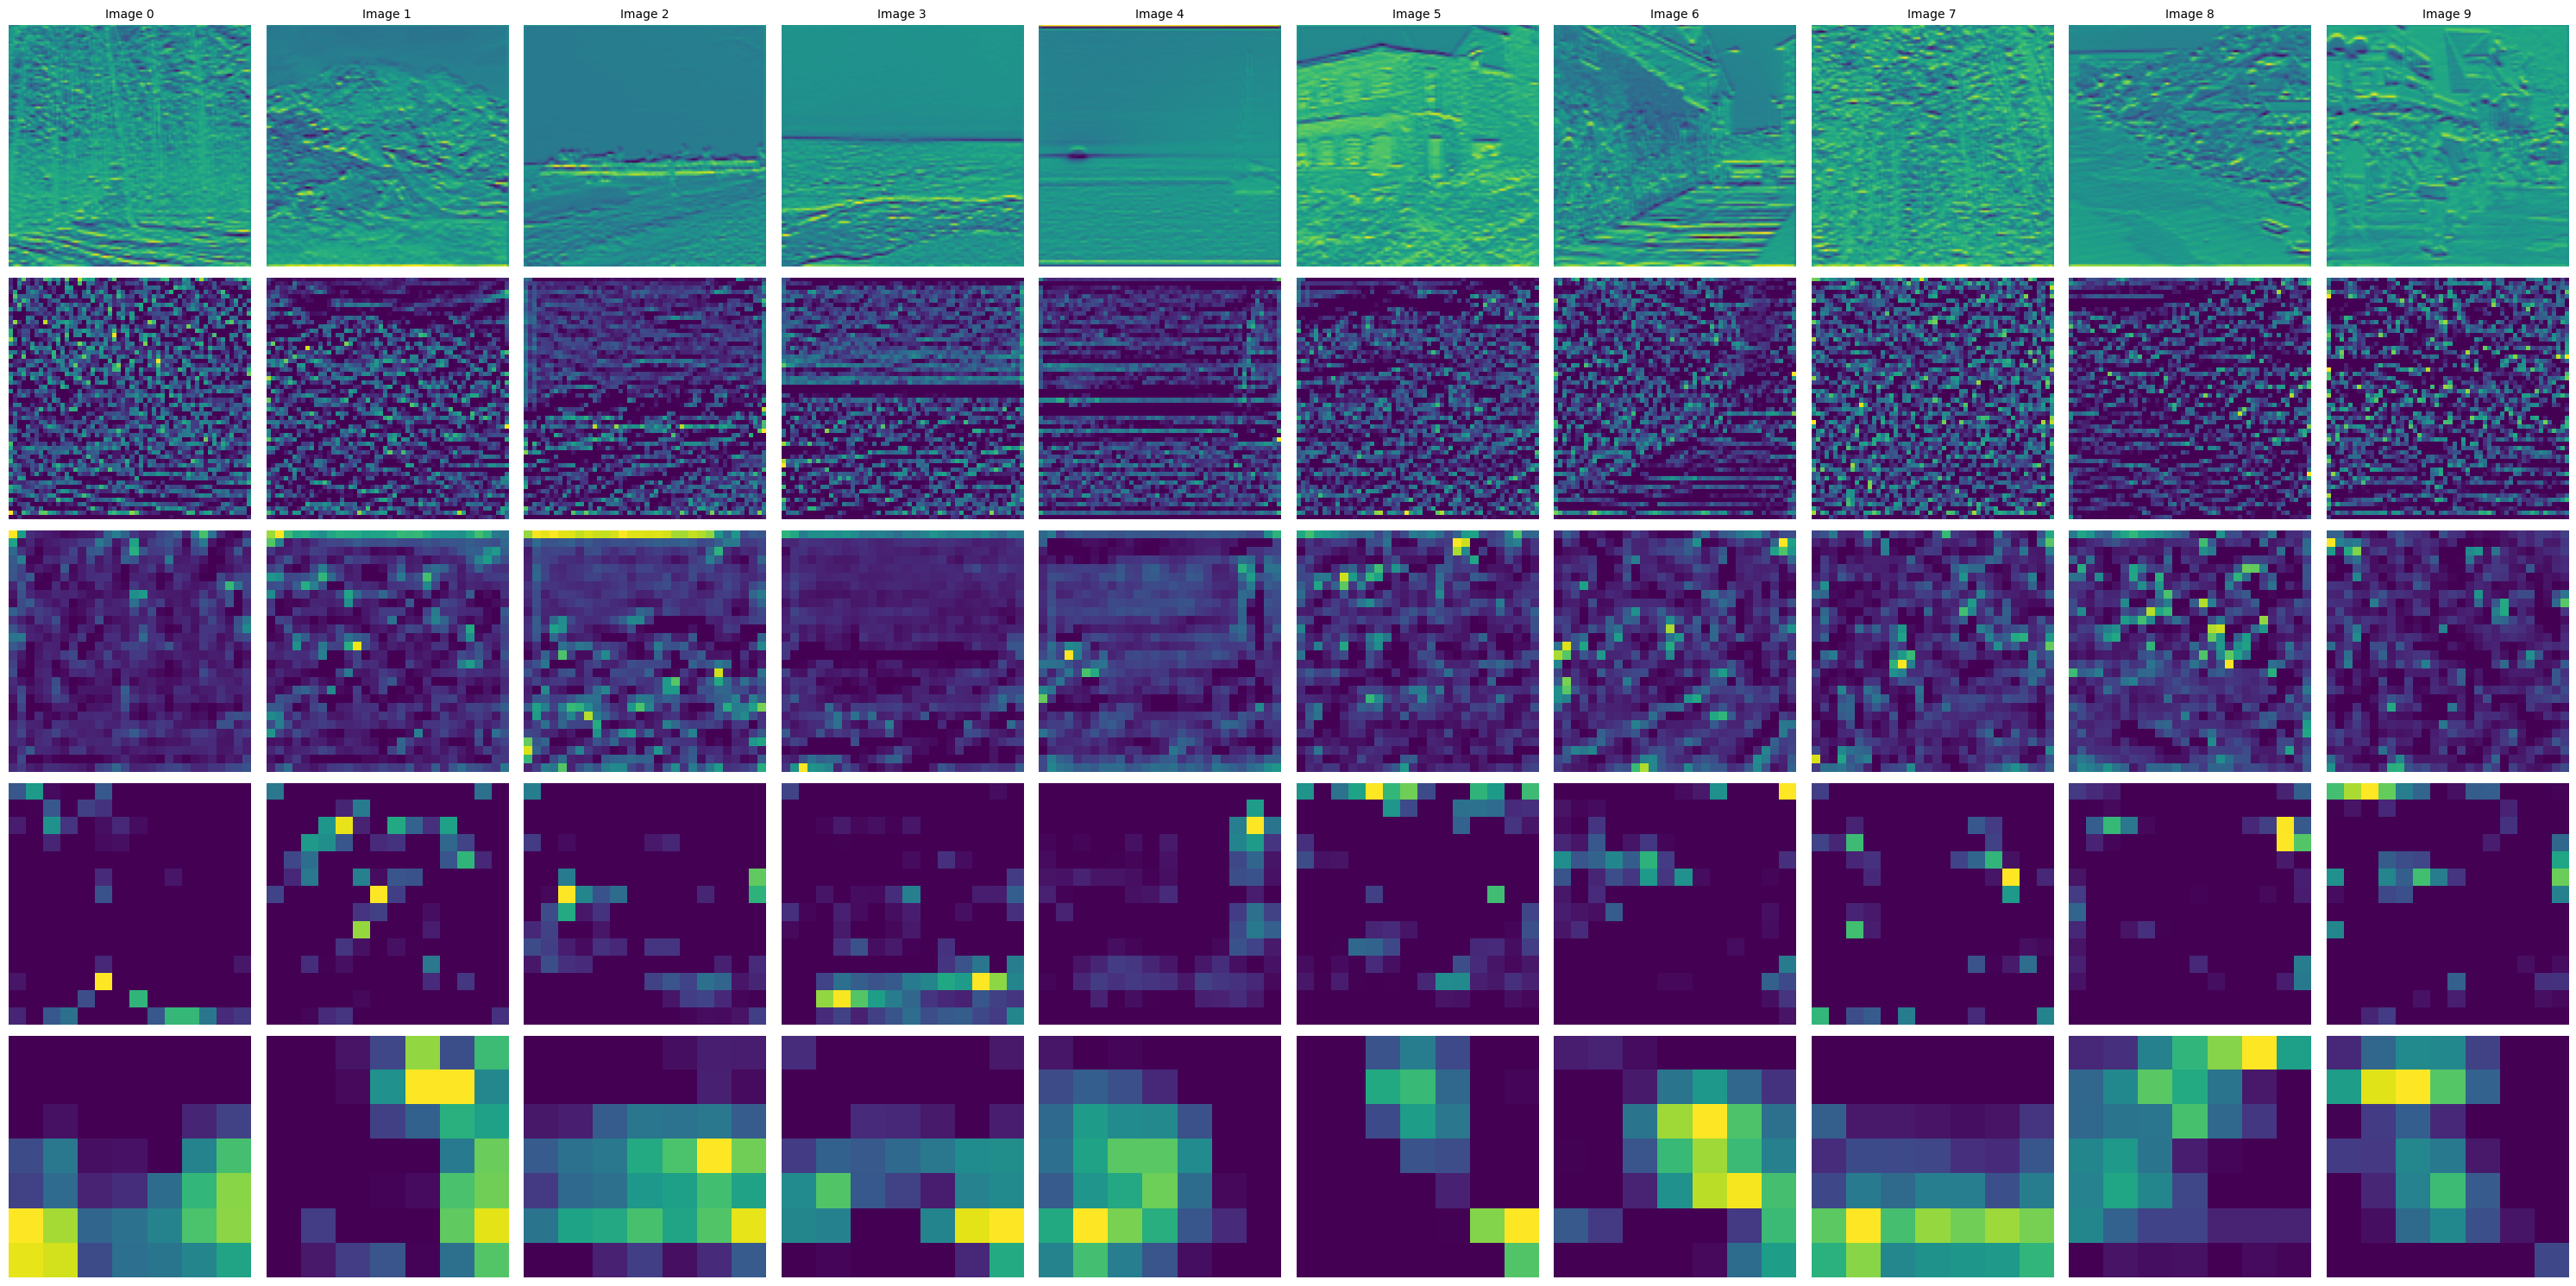

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_maps_grid(feature_maps, image_idx_list, layer_names, num_filters=5):
    """
    Plot feature maps som et grid:
    - Rader = forskjellige lag (f.eks. conv1, layer2, layer4)
    - Kolonner = forskjellige bilder (f.eks. image_0, image_1, image_2)
    """
    
    num_images = len(image_idx_list)
    num_layers = len(layer_names)

    fig, axes = plt.subplots(num_layers, num_images, figsize=(num_images * 3, num_layers * 3))

    for row, layer_name in enumerate(layer_names):
        feature_map = feature_maps[layer_name]

        for col, img_idx in enumerate(image_idx_list):
            ax = axes[row, col] if num_layers > 1 else axes[col]  # Håndter 1-rads tilfelle
            fm = feature_map[img_idx]  # Velg feature map for dette bildet

            # Velg et filter (kan også ta gjennomsnitt over alle filters)
            selected_filter = fm[0].cpu().numpy()  # Tar første filter

            ax.imshow(selected_filter, cmap="viridis")
            ax.axis("off")

            # Legg til labels for første rad og første kolonne
            if row == 0:
                ax.set_title(f"Image {img_idx}", fontsize=10)
            if col == 0:
                ax.set_ylabel(layer_name, fontsize=12)

    plt.tight_layout()
    plt.show()

# Eksempelbruk
image_idx_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Plott fire bilder
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']  # Lagene vi ser på
plot_feature_maps_grid(feature_maps, image_idx_list, layer_names)
